<a href="https://colab.research.google.com/github/STRMNGnwo/Masters-Thesis/blob/main/Srinivas_Masters_Thesis_TextBased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [1]:
!pip install -q --upgrade keras-cv
!pip install nltk

#used to perform semantic similarity analysis after evolutionary operators are used (to make sure they make sense)
!pip install sentence_transformers
!pip install language_tool_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.7 MB/s eta 0:00:00


# Imports/ Downloads

In [2]:
#fundamental imports
import os
import sys
import random
import torch
import nltk

In [ ]:
#downloads that are necessary for the NLP based mutation and cross-over to occur

nltk.download('punkt')

#used to perform pos tagging (used to only mutate adjectives, verbs and nouns in mutation-synonym based and also contextual )
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

#used to obtain synonyms during mutation
nltk.download('words')
nltk.download('wordnet')

#used to ignore/remove stopwords during mutation
nltk.download('stopwords')

In [3]:
from google.colab import files
from google.colab import drive


drive.mount("/content/drive/")
sys.path.insert(0, '/content/drive/MyDrive/Masters-Thesis-Datasets/')

Mounted at /content/drive/


# Checking if GPU is available (and asking Colab to use it if it is)

In [4]:
if torch.cuda.is_available():
  DEVICE=torch.device("cuda")
  torch.cuda.get_device_name(0)
  print("GPU")

else:
  DEVICE="cpu"
  print("CPU")

GPU


# Importing and initialising a text to image stable diffusion model

In [5]:
import time
import keras_cv
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend


In [6]:
model = keras_cv.models.StableDiffusion(
    img_width=512, img_height=512, jit_compile=False
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# Function to plot images

In [7]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# Importing a text file containing some prompts

Also importing some reference (ground truth) images that the prompts should ideally generate

In [ ]:
!unzip /content/drive/MyDrive/Masters-Thesis-Datasets/VanGogh.zip

# Evolutionary Computing Aspects

### Model Trial

In [ ]:
# trial generation of an image from initial population
from PIL import Image
reference_image_path="/content/VincentVanGogh/Watercolors/Fishing Boats on the Beach.jpg"

reference_image= Image.open(reference_image_path)

trial_prompt_1="Four colorful boats are on a beach next to the ocean."
trial_prompt_2="Vibrant boats rest on an orange beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings."

198180272/198180272 [==============================] - 1s 0us/step


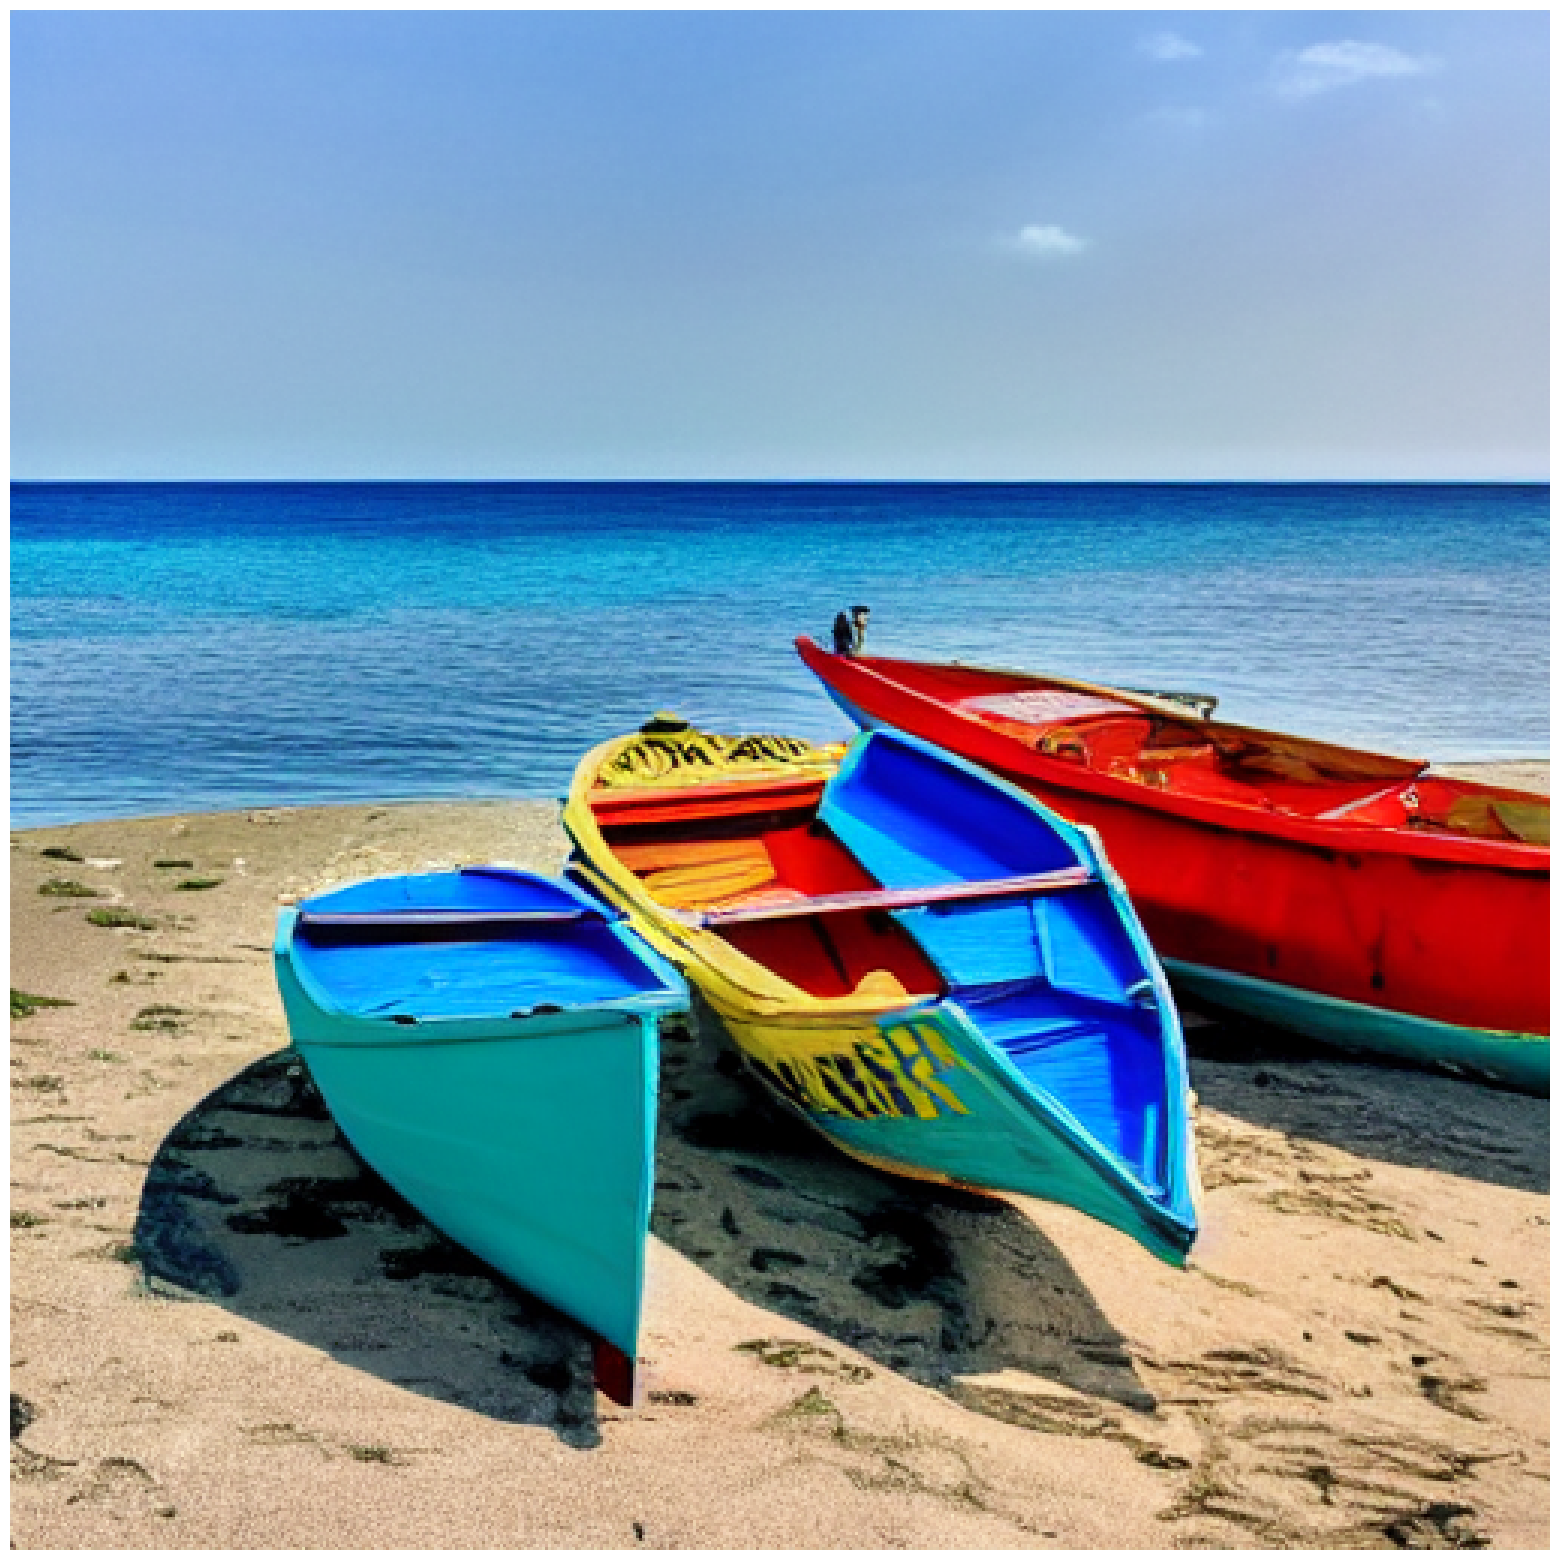

In [11]:
image_1 = model.text_to_image(trial_prompt_1, batch_size=1)
plot_images(image_1)

198180272/198180272 [==============================] - 1s 0us/step


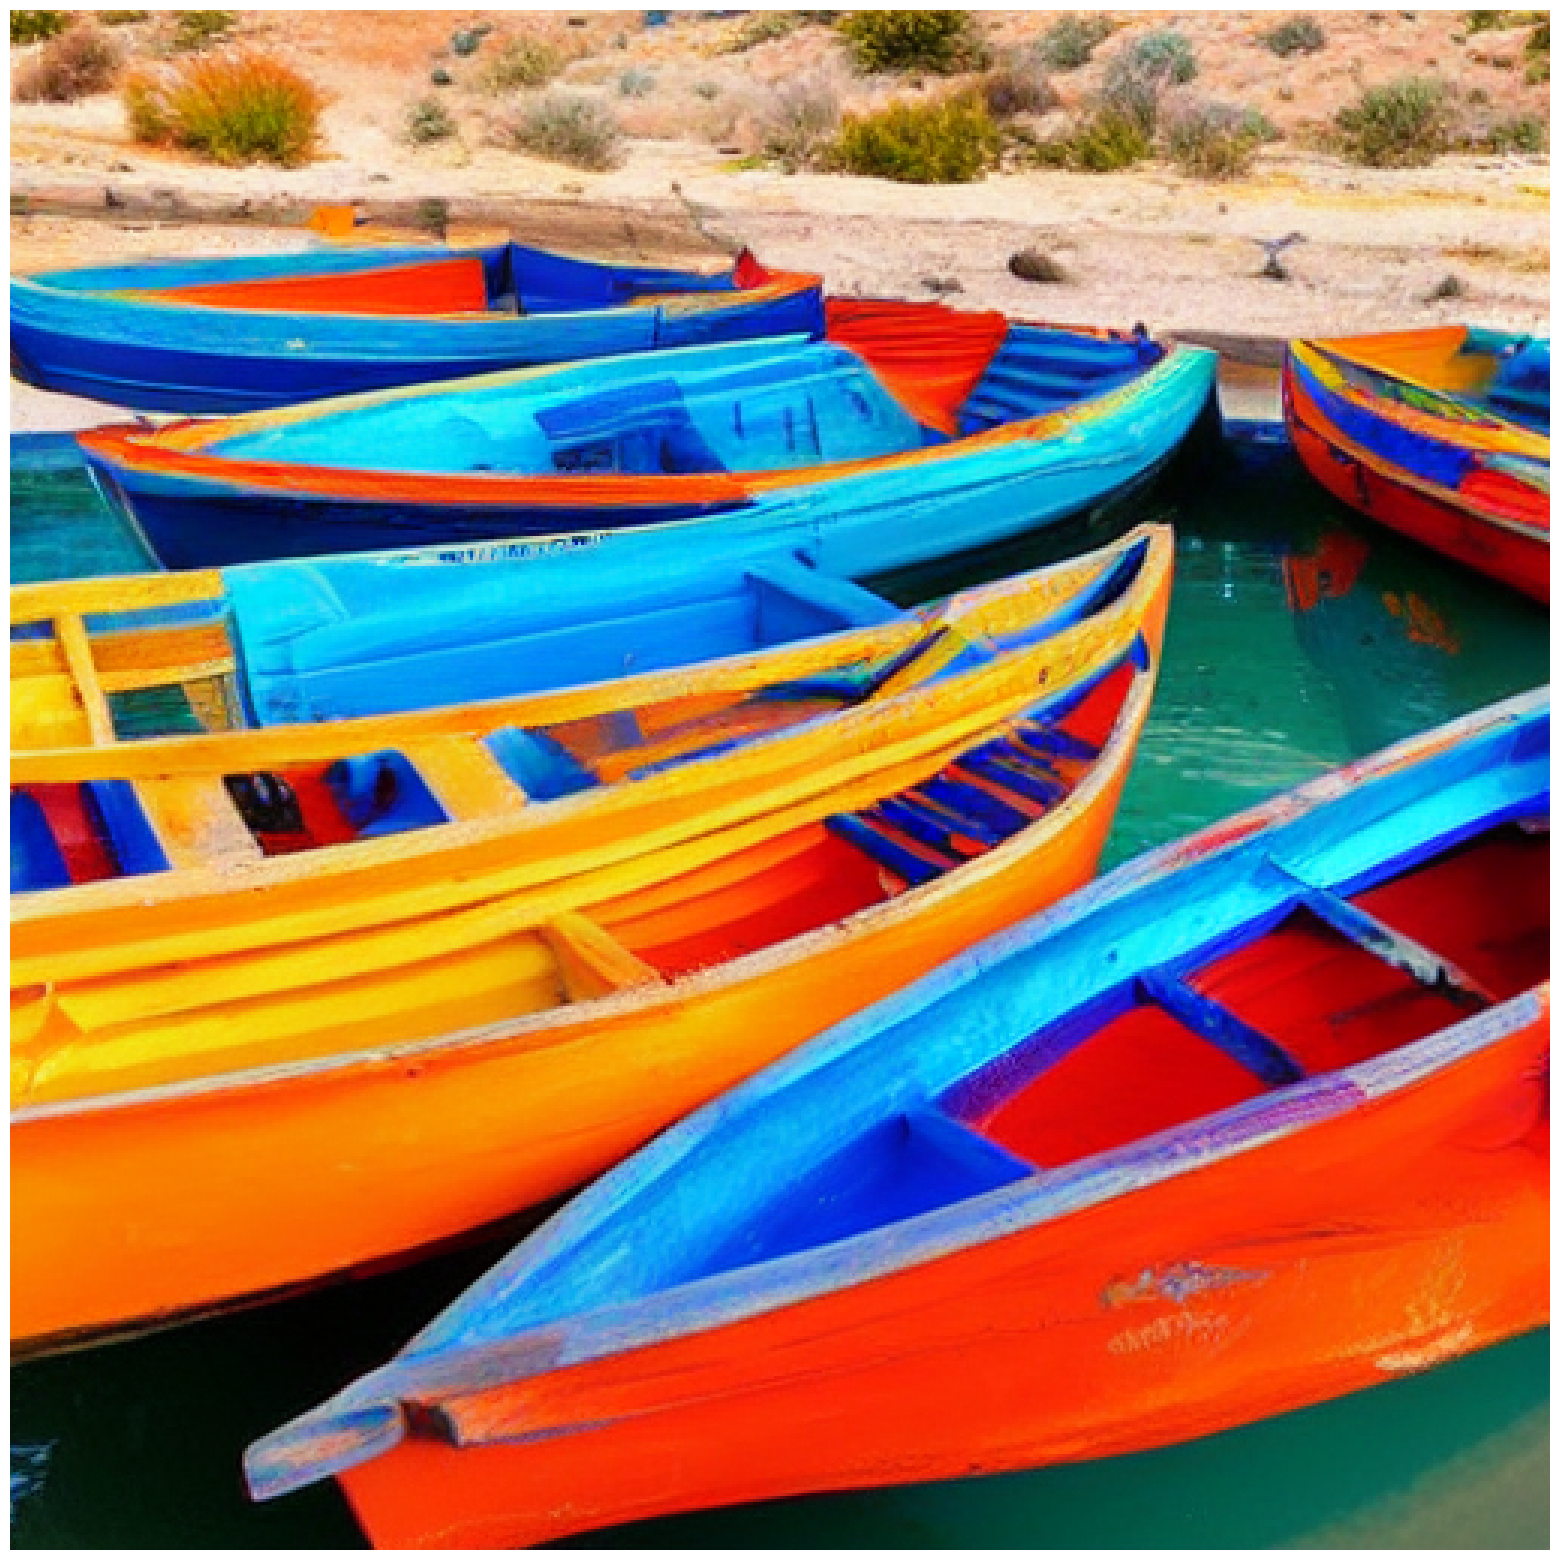

In [9]:
image_2 = model.text_to_image("'Vibrant boats rest on an Orange_River beach under a vivid blue sky , their bold colors creating a collide_with contrast with the instinctive surroundings .'", batch_size=1)
plot_images(image_2)

### Helper function to generate images for a prompt

In [ ]:
def generate_image(individual):
  generated_image=model.text_to_image(individual["prompt"], batch_size=1)
  return generated_image

### NLP helper functions to aid mutation and cross-over

In [ ]:
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag, word_tokenize
from nltk.chunk import ne_chunk
import random
from sentence_transformers import SentenceTransformer, util
import language_tool_python

vocab = ["a", "beautiful", "sunset", "over", "the", "ocean", "with", "clouds", "and", "birds", "flying", "calm", "sea", "during"]
stop_words = set(stopwords.words('english'))

#used to check if sentance after mutation and cross-over is grammatically correct and semantically similar
tool = language_tool_python.LanguageTool('en-US')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
def is_sentence_semantically_similar(original_sentence, mutated_sentence, threshold=0.7):
    embeddings = model.encode([original_sentence, mutated_sentence])
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
    print("Similarity is: "+str(similarity))
    return similarity >= threshold

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)
    return list(synonyms)

def extract_phrases(sentence):
    words = word_tokenize(sentence)
    tagged = pos_tag(words)
    chunks = ne_chunk(tagged)
    phrases = []
    current_phrase = []
    for chunk in chunks:
        if hasattr(chunk, 'label'):
            current_phrase.append(' '.join(c[0] for c in chunk))
        else:
            if current_phrase:
                phrases.append(' '.join(current_phrase))
                current_phrase = []
            phrases.append(chunk[0])
    if current_phrase:
        phrases.append(' '.join(current_phrase))
    return phrases


sentence = "The quick brown fox jumps over the lazy dog near the Eiffel Tower."
phrases = extract_phrases(sentence)
print(phrases)

### Defining the fitness function

In [ ]:
from skimage.metrics import structural_similarity as ssim

def fitness_function(individual):

  #basic score-> compare similarity between generated image and reference image
  #similarity determined by Structural Similarity Index which considers changes in structural information, luminance, and contrast
  # ssim value ranges from -1 to 1

  ssim_index, _ = ssim(individual["image"], reference_image, full=True)
  print(f'SSIM: {ssim_index}')


### Defining the mutation function

In [ ]:
import random as rd
# The MUTATION operator

def synonym_mutate(sentence, mutation_rate=0.1):
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    for i in range(len(words)):
        word, pos = pos_tags[i]
        if word.lower() not in stop_words and pos in  ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:  # Adjectives, Verbs and Nouns
            if random.random() < mutation_rate:
                synonyms = get_synonyms(word)
                if synonyms:
                    words[i] = random.choice(synonyms)
    #only return the mutated sentence if it is semantically similar to version pre-mutation (could help avoid boat becoming gravy holder and stuff like that )
    if is_sentence_semantically_similar(sentence,' '.join(words)):
      #print(' '.join(words)+" is similar to "+ sentence)
      return ' '.join(words)

    return sentence

# Contextual mutation can be used in later stages of the experimentation process, its not ready yet.

#TO DO: Vocabulary should be all words in the initial population of prompts (should I update vocabulary after every generation?).
# Also for the replace bit-> should POS tag all words in prompt being mutated, POS tag vocabulary and then replace noun with noun, verb with verb etcetera.
def contextual_mutation(sentence, vocab, mutation_rate=0.1):
    words = word_tokenize(sentence)
    for i in range(len(words)):
        if random.random() < mutation_rate:
            #action = random.choice(['replace', 'add', 'remove'])
            action="replace"
            if action == 'replace':
                words[i] = random.choice(vocab)
            elif action == 'add':
                words.insert(i, random.choice(vocab))
            elif action == 'remove' and len(words) > 1:
                words.pop(i)
    return ' '.join(words)

# trialling out both the synonym and context based mutations
sentence = "Vibrant boats rest on an orange beach under a vivid blue sky, their bold colors creating a striking contrast with the natural surroundings."

mutated_sentence1 = synonym_replacement(sentence)
mutated_sentence2 = contextual_mutation(sentence, vocab)
print(f'Mutated Sentence 1 [Synonym based]: {mutated_sentence1}')
print(f'Mutated Sentence 2 [Contextual]: {mutated_sentence2}')


In [ ]:
def mutate_population(population,mutation_rate):


In [ ]:
#phrase based crossover
def phrase_based_crossover(parent1, parent2):
    parent1_phrases = extract_phrases(parent1)
    parent2_phrases = extract_phrases(parent2)

    if len(parent1_phrases) > 1 and len(parent2_phrases) > 1:
        crossover_point1 = random.randint(1, len(parent1_phrases) - 1)
        crossover_point2 = random.randint(1, len(parent2_phrases) - 1)

        child1_phrases = parent1_phrases[:crossover_point1] + parent2_phrases[crossover_point2:]
        child2_phrases = parent2_phrases[:crossover_point2] + parent1_phrases[crossover_point1:]

        #TO DO: Check semantic similarity with parents?
        return ' '.join(child1_phrases), ' '.join(child2_phrases)
    else:
        return parent1, parent2

parent1 = sentence1
parent2 = sentence2

#trialling out the phrase based cross-over
child1, child2 = phrase_based_crossover(parent1, parent2)
print(f'Child 1: {child1}')
print(f'Child 2: {child2}')


In [ ]:
# The CROSSOVER operator
def crossover_population(population,num_parents=2):



In [ ]:
#fight function and tournament selection function
def fight(fight_participants):
  currWinner = fight_participants[0]
    #loop through participants and identify individual with highest fitness
    for i in range(1, len(fight_participants)):
        if fight_participants[i]["fitness"] > currWinner["fitness"]:
            currWinner = fight_participants[i]
    return currWinner

# Tournament selection function should return winners of the tournament
def tournament_selection(population, tournament_size,reference_image=reference_image):
    strongest_individuals=[]

    #making sure every text prompt is involved in the fight
    num_rounds=round(len(population)/tournament_size)
    for i in range(0, num_fights):

        #giving some prompts a pass or a by if a fight doesn't have enough participants
        if (len(population)<tournament_size):
            for p in population:
                strongest_individuals.append(p)
            return strongest_individuals


        #randomly choosing tournament_size fighters to fight
        individuals_to_fight=rd.sample(population,tournament_size)

        #getting the winner of the fight and adding him to winners list
        strongest_individuals.append(fight(individuals_to_fight))

        #remove combatants from population (a prompt that has already "fought" won't fight again)
        for fighter in individuals_to_fight:
            population.remove(fighter)

    return strongest_individuals


In [ ]:
#function that loops through population and evaluates/assigns fitness for each individual

def evaluate_population_fitness(population):

  fitness_population=population
  for index,individual in enumerate(fitness_population):
    individual["fitness"]=fitness_function(individual)

  return fitness_population

### Defining the basic parameters of the Genetic Algorithm's evolutionary loop

### Initialising the population of prompts and the image they should ideally generate

In [ ]:
#initially population initialisation can be just reading in the text file of pre-defined prompts
def initialise_population(pop_size):

  #population is going to be a list of dict objects
  # population=[individual1:{"prompt":"a description of the image","fitness":fitness score, "image":generatedimage}, individual2]
  initial_population=[]

  #initially setting fitness to a very low value for every prompt/text description
  for prompt in textfile:
    individual["prompt"]=prompt
    individual["image"]=generate_image(individual)
    individual["fitness"]=-1000


### Running the loop

In [ ]:
#Evolutionary loop

initial_population=initialise_population(20)

#initialise population should take care of initial image generation for each prompt.
#Fitness still needs to be calculated

population=initial_population

for generation in total generations:

  #evaluate fitness of entire population
  evaluate_population_fitness(population)

  #tournament selection
  winners=tournament_selection(population=population,tournament_size=2)
  population=winners

  #crossover between winners to generate children which are then added to the population
  crossed_over_children=crossover_population(population,2) #giving the function the population and the number of parents involved in a crossover
  population.extend(crossed_over_children)

  #mutation
  mutate_population(population=population,mutation_rate=0.1)


  #generate "new" images for current individual prompts in population
  for individual in population:
    individual["image"]=generate_image(individual)

  #end of generation

#end of evolutionary loop


#Experimental stuff /Old code